# Segmentation Model

  - Using [segmentation_model.pytorch](https://github.com/qubvel/segmentation_models.pytorch) and **DeepLabV3** for **multi class** semantic segmentation

Thanks to **Shubhamaicrowd** for the starter Notebook. This notebook is few enhanced version developed from the inspiration of the Starter Notebook 

**Note: The semantic segmentation dataset was generated using the Carla Simulator. The dataset contains over 23 different classes.**

# Downloading Dataset

Installing `aicrowd-cli`

In [ ]:
!pip install aicrowd-cli # aicrowd client 설치

In [ ]:
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/y0uwHzbKfQrUwhRwrgbN5VQYnoa3ZZTR05BAyAncgKU
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!pip install segmentation-models-pytorch==0.2.1 # 모델에 맞는 torch version 설치

In [ ]:
!git clone https://github.com/qubvel/segmentation_models.pytorch.git

Cloning into 'segmentation_models.pytorch'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 6.04 MiB | 3.99 MiB/s, done.
Resolving deltas: 100% (918/918), done.


In [ ]:
!gdown 1D0DCIWuWlva9scIvBzZwKWzQA9V4IsZb

Downloading...
From: https://drive.google.com/uc?id=1D0DCIWuWlva9scIvBzZwKWzQA9V4IsZb
To: /content/NewDeepLabv3Plus_Multi_PNGdata.zip
100% 9.58M/9.58M [00:00<00:00, 38.5MB/s]


In [ ]:
!unzip /content/NewDeepLabv3Plus_Multi_PNGdata.zip

In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c scene-segmentation -o data

test.zip:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [ ]:
!unzip data1/train.zip -d data1/train > /dev/null
!unzip data1/test.zip -d data1/test > /dev/null

# Downloading & Importing Libraries

Here we are going to use segmentation_models.pytorch which is a really popular library providing a tons of different segmentation models for pytorch including basic unets to DeepLabV3!

In [ ]:
!pip install natsort # str 형태의 파일명에게서 정수형 형태를 정렬해주는 natsort 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
from natsort import natsorted
from tqdm.notebook import tqdm
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Create Train & Validation Dataset

**Prepare the train & validation dataset**

In [ ]:
IMAGE_PATH = './data/train/image/'
MASK_PATH = './data/train/segmentation/'

In [ ]:
n_classes = 23

def create_df():
    name = [] 
    for dirname, _, filenames in os.walk(IMAGE_PATH): # 이미지 패스에서 불러와서
        for filename in filenames:
            name.append(filename.split('.')[0]) # 빈 리스트인 name에  .을 기준으로 스플릿 한 파일명 중 앞 (id)를 저장
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))) #name의 총합을 인덱스로 지정하고 저장한 id를 딕셔너리 형태로 지정

df = create_df()
print('Total Images: ', len(df))

Total Images:  304


In [ ]:
df

,id
0,c_26
1,a_035
2,c_75
3,a_044
4,a_094
...,...
299,c_43
300,d_0250
301,b_0172
302,a_012


In [ ]:
#split data
X_train, X_val = train_test_split(df['id'].values, test_size=0.20, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  243
Val Size     :  61


In [ ]:
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/train/image
!mkdir dataset/train/segmentation

!mkdir dataset/val
!mkdir dataset/val/image
!mkdir dataset/val/segmentation

In [ ]:
!ls

data	 NewDeepLabv3Plus_Multi_PNGdata.zip  segmentation_models.pytorch
dataset  sample_data


In [ ]:
import shutil # 원본인 'data'파일의 파일명을 활용해 'dataset'에 카피
 
source = "./data/train"
destination = "dataset/train"

for i in os.listdir(os.path.join(source,"image")):
    if i.split('.')[0] in X_train:
        shutil.copy(os.path.join(source,"image",i), os.path.join(destination,"image",i))

for i in os.listdir(os.path.join(source,"segmentation")):
    if i.split('.')[0] in X_train:
        shutil.copy(os.path.join(source,"segmentation",i), os.path.join(destination,"segmentation",i))
        
source = "./data/train"
destination = "dataset/val"

for i in os.listdir(os.path.join(source,"image")):
    if i.split('.')[0] in X_val:
        shutil.copy(os.path.join(source,"image",i), os.path.join(destination,"image",i))

for i in os.listdir(os.path.join(source,"segmentation")):
    if i.split('.')[0] in X_val:
        shutil.copy(os.path.join(source,"segmentation",i), os.path.join(destination,"segmentation",i))

Image Size (512, 512, 3)
Mask Size (512, 512)


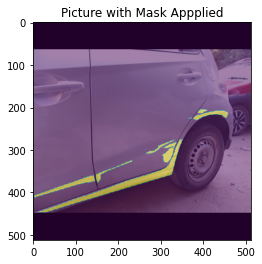

In [ ]:
# 위에서 지정한 'IMAGE_PATH' 에 'id'100번의 파일을 가져와
img = Image.open(IMAGE_PATH + df['id'][50] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][50] + '.png')
print('Image Size', np.asarray(img).shape) # 이미지 상태의 파일을 np.asarray 형태로 만들어 shape을 확인하고
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.5) # 이미지와 마스크의 겹치는 부분 테스트 (alpha는 투명도 조절)
plt.title('Picture with Mask Appplied')
plt.show()

# Creating the Dataloader

In this section, we will be creating the dataloader that our model will use for the loading batches of corrosponding features and labels for training & testing

# 우리 데이터

## image 전처리

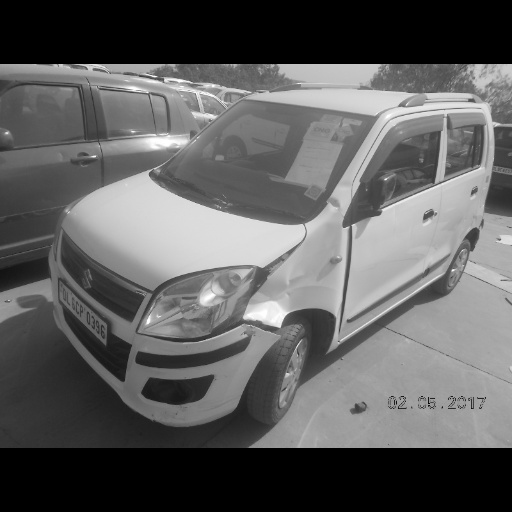

In [ ]:
img = Image.open(os.path.join('/content/segmentation_models.pytorch/dataset/train/image/a_012.jpg'))
img = img.convert("L")
img

In [ ]:
img = np.array(img, dtype=np.float32) 
print(img)
print(img.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(512, 512)


In [ ]:
img = img[np.newaxis, :, :] # 차원 추가 []가 하나씩 더 생김
print(img)
print(img.shape)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(1, 512, 512)


In [ ]:
img = torch.from_numpy(img) # np 배열을 torch 형태로 변화
print(img)
print(img.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 512, 512])


In [ ]:
img = img.float()/255 # 실수형으로 숫자를 바꾼 뒤 255로 나눠서 정규화 진행
print(img)
print(img.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 512, 512])


## mask 전처리 (우리 데이터 실험)


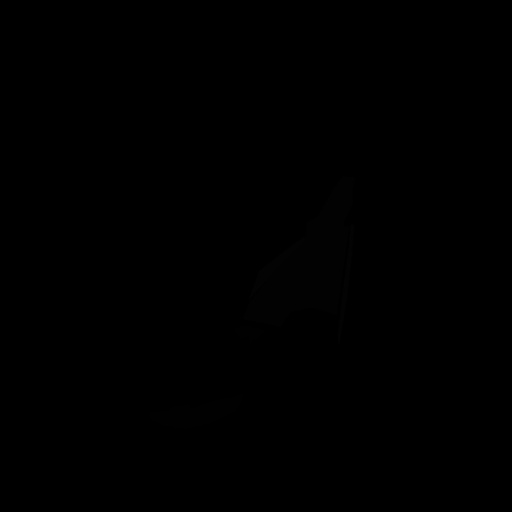

In [ ]:
mask = Image.open(os.path.join('/content/segmentation_models.pytorch/dataset/train/segmentation/a_012.jpg'))
mask

In [ ]:
mask = cv2.imread('/content/segmentation_models.pytorch/dataset/train/segmentation/a_012.jpg', cv2.IMREAD_GRAYSCALE)
mask.shape

(512, 512)

In [ ]:
mask = np.array(mask, dtype=np.float32) # 이미지 형태의 마스크를 실수형인 array 형태로 변환
print(mask)
print(mask.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(512, 512)


In [ ]:
labels = list(range(0, 5)) # 0부터 5까지 있는 리스트 생성
binary_mask = np.array([(mask == v) for v in list(labels)]) # 마스크를 value로 지정하고 위에 생성한 리스트를 포문을 돌려 적용
print(binary_mask)
print(binary_mask.shape)  # 결과로는 0인 값은 True, 아닌 값은 False로 나옴

[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  

In [ ]:
binary_mask = np.stack(binary_mask, axis=-1).astype('float') # 맨 앞이 1인 

print(binary_mask) 
print(binary_mask.shape) 

[[[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  ...
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  ...
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  ...
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 ...

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  ...
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  ...
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  ...
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]]
(512, 512, 5)


In [ ]:
mask_preprocessed = binary_mask.transpose(2, 0, 1)
mask_preprocessed.shape

(5, 512, 512)

In [ ]:
# mask_preprocessed = binary_mask.transpose(0, 1, 3, 2)
# mask_preprocessed.shape

In [ ]:
mask_preprocessed = torch.from_numpy(mask_preprocessed)
mask_preprocessed.shape

torch.Size([5, 512, 512])

In [ ]:
img = np.array(img, dtype=np.float32)
mask = np.array(mask, dtype=np.float32)

# Change image channel ordering
img = img[np.newaxis, :, :]


# Normalizing images
img = torch.from_numpy(img)
img = img.float()/255

binary_mask = np.array([(mask == v) for v in list(self.labels)])
binary_mask = np.stack(binary_mask, axis=-1).astype('float')

mask_preprocessed = binary_mask.transpose(2, 0, 1)
mask_preprocessed = torch.from_numpy(mask_preprocessed)

In [ ]:
!gdown 1-3KDShTJYgOkCH5Go6oUIod1jlq7zqG7

In [ ]:
!unzip /content/segmentation_models.pytorch/dataset2.zip

In [ ]:
asd = list(range(0, 5))
asd

## mask 전처리 (기존 데이터)

In [ ]:
import cv2

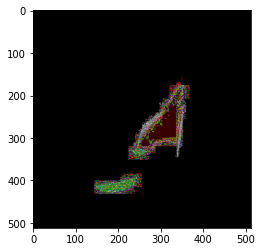

In [ ]:
mask = cv2.imread(os.path.join('/content/dataset/train/segmentation/a_012.png'))
plt.imshow(mask*100)
# mask

In [ ]:
mask.shape

(512, 512, 3)

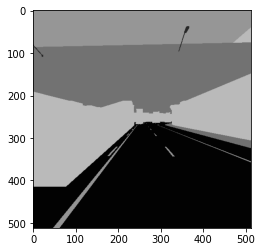

In [ ]:
mask = cv2.imread(os.path.join('/content/data1/train/segmentation/10.png'))
plt.imshow(mask*110)

In [ ]:
mask.shape

(512, 512, 3)

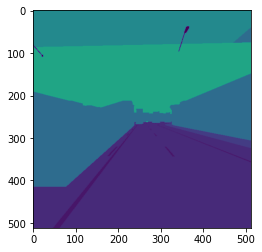

In [ ]:
mask = Image.open(os.path.join('/content/data1/train/segmentation/10.png'))
plt.imshow(mask)

In [ ]:
mask = Image.open(os.path.join('/content/data1/train/segmentation/10.png'))
mask = np.array(mask, dtype=np.float32)
mask

array([[13., 13., 13., ..., 13., 13., 13.],
       [13., 13., 13., ..., 13., 13., 13.],
       [13., 13., 13., ..., 13., 13., 13.],
       ...,
       [ 7.,  7.,  7., ...,  7.,  7.,  7.],
       [ 7.,  7.,  7., ...,  7.,  7.,  7.],
       [ 7.,  7.,  7., ...,  7.,  7.,  7.]], dtype=float32)

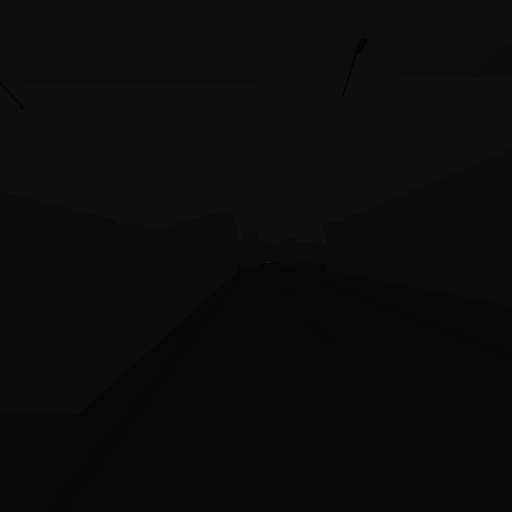

In [ ]:
mask

In [ ]:
mask = np.array(mask, dtype=np.float32) # 이미지 형태의 마스크를 실수형인 array 형태로 변환
print(mask)
print(mask.shape)

[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [ 7.  7.  7. ...  7.  7.  7.]
 [ 7.  7.  7. ...  7.  7.  7.]
 [ 7.  7.  7. ...  7.  7.  7.]]
(512, 512)


In [ ]:
labels = list(range(0, 5)) # 0부터 5까지 있는 리스트 생성
binary_mask = np.array([(mask == v) for v in list(labels)]) # 마스크를 value로 지정하고 위에 생성한 리스트를 포문을 돌려 적용
print(binary_mask)
print(binary_mask.shape)  # 결과로는 0인 값은 True, 아닌 값은 False로 나옴

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  

In [ ]:
binary_mask = np.stack(binary_mask, axis=-1).astype('float') # 맨 앞이 1인 

print(binary_mask) 
print(binary_mask.shape) 

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
(512, 512, 5)


In [ ]:
mask_preprocessed = binary_mask.transpose(2, 0, 1)

In [ ]:
mask_preprocessed = binary_mask.transpose(1, 2, 0)
print(mask_preprocessed)
print(mask_preprocessed.shape)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(512, 5, 512)


In [ ]:
mask_preprocessed = torch.from_numpy(mask_preprocessed)
mask_preprocessed.shape

torch.Size([5, 512, 512])

In [ ]:
img = np.array(img, dtype=np.float32)
mask = np.array(mask, dtype=np.float32)

# Change image channel ordering
img = img[np.newaxis, :, :]


# Normalizing images
img = torch.from_numpy(img)
img = img.float()/255

binary_mask = np.array([(mask == v) for v in list(self.labels)])
binary_mask = np.stack(binary_mask, axis=-1).astype('float')

mask_preprocessed = binary_mask.transpose(2, 0, 1)
mask_preprocessed = torch.from_numpy(mask_preprocessed)

In [ ]:
!gdown 1-3KDShTJYgOkCH5Go6oUIod1jlq7zqG7

Downloading...
From: https://drive.google.com/uc?id=1-3KDShTJYgOkCH5Go6oUIod1jlq7zqG7
To: /content/segmentation_models.pytorch/dataset2.zip
100% 20.4M/20.4M [00:00<00:00, 128MB/s] 


In [ ]:
!unzip /content/segmentation_models.pytorch/dataset2.zip

In [ ]:
asd = list(range(0, 5))
asd

[0, 1, 2, 3, 4]

## Pre-processing

In [ ]:
cd /content/segmentation_models.pytorch

/content/segmentation_models.pytorch


In [ ]:
#@title
class SemanticSegmentationDataset(Dataset):
    
    def __init__(self, img_directory=None, label_directory=None, train=True):
        self.img_directory = img_directory
        self.label_directory = label_directory            

        if img_directory != None:
            if train:
                self.img_list = natsorted(os.listdir(img_directory))
            else:
                self.img_list = natsorted(os.listdir(img_directory))

        if train:
            self.label_list = natsorted(os.listdir(label_directory))

        self.train = train

        self.labels = list(range(0, 5))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        # Reading the image
        img = Image.open(os.path.join(self.img_directory, self.img_list[idx]))
        img = img.convert("L") # grayscale

        if self.train == True:
          
            # Reading the mask image
            mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))
            # mask = cv2.imread(os.path.join(self.label_directory, self.label_list[idx]), cv2.IMREAD_GRAYSCALE)

            # mask.show()
            img = np.array(img, dtype=np.float32)
            mask = np.array(mask, dtype=np.float32)

            # Change image channel ordering
            img = img[np.newaxis, :, :]


            # Normalizing images
            img = torch.from_numpy(img)
            img = img.float()/255

            binary_mask = np.array([(mask == v) for v in list(self.labels)])
            binary_mask = np.stack(binary_mask, axis=-1).astype('float')

            mask_preprocessed = binary_mask.transpose(2, 0, 1)
            mask_preprocessed = torch.from_numpy(mask_preprocessed)

            return img, mask_preprocessed
        
        # If reading test dataset, only return image 
        else:
          
            img = np.array(img, dtype=np.float32)
            img = img[np.newaxis, :, :]
            # img = np.moveaxis(img, -1, 0)

            # Normalizing images
            img = torch.from_numpy(img)
            img = img.float()/255
          
            return img

In [ ]:
class SemanticSegmentationDataset(Dataset):
    
    def __init__(self, img_directory=None, label_directory=None, train=True):
        self.img_directory = img_directory
        self.label_directory = label_directory            

        if img_directory != None:
            if train:
                self.img_list = natsorted(os.listdir(img_directory))
            else:
                self.img_list = natsorted(os.listdir(img_directory))

        if train:
            self.label_list = natsorted(os.listdir(label_directory))

        self.train = train

        self.labels = list(range(0, 23))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        # Reading the image
        img = Image.open(os.path.join(self.img_directory, self.img_list[idx]))
        img = img.convert("L")

        if self.train == True:
          
            # Reading the mak image
            mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))

            # mask.show()
            img = np.array(img, dtype=np.float32)
            mask = np.array(mask, dtype=np.float32)

            # Change image channel ordering
            img = img[np.newaxis, :, :]


            # Normalizing images
            img = torch.from_numpy(img)
            img = img.float()/255

            binary_mask = np.array([(mask == v) for v in list(self.labels)])
            binary_mask = np.stack(binary_mask, axis=-1).astype('float')

            mask_preprocessed = binary_mask.transpose(2, 0, 1)
            mask_preprocessed = torch.from_numpy(mask_preprocessed)

            return img, mask_preprocessed
        
        # If reading test dataset, only return image 
        else:
          
            img = np.array(img, dtype=np.float32)
            img = img[np.newaxis, :, :]
            # img = np.moveaxis(img, -1, 0)

            # Normalizing images
            img = torch.from_numpy(img)
            img = img.float()/255
          
            return img

In [ ]:
data_dir = "dataset"

# Creating the training dataset
train_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir,"train/image"), 
                                            label_directory=os.path.join(data_dir,"train/segmentation"))
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=True)

# Creating the validation dataset
val_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir,"val/image"), 
                                            label_directory=os.path.join(data_dir,"val/segmentation"))
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=True)


In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 23, 512, 512]))

In [ ]:
#@title
import cv2
import os
from google.colab.patches import cv2_imshow

test = cv2.imread('/content/segmentation_models.pytorch/dataset/train/image/a_010.jpg')
test.shape
# cv2_imshow(test)

In [ ]:
#@title
import cv2
import os
from google.colab.patches import cv2_imshow

test = cv2.imread('/content/segmentation_models.pytorch/dataset/train/segmentation/a_010.jpg')
# test.shape
cv2_imshow(test*100)

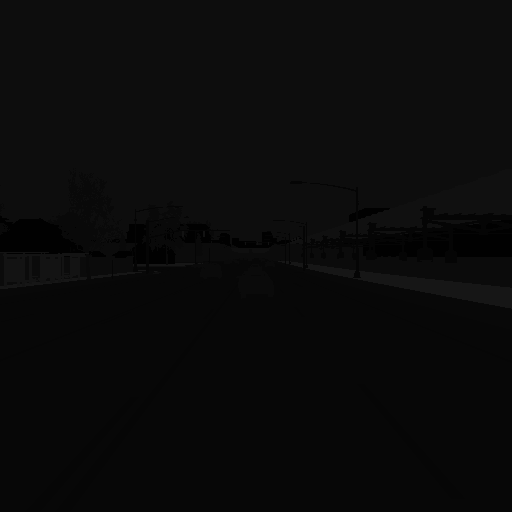

(512, 512, 3)

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

test = cv2.imread('/content/segmentation_models.pytorch/dataset/val/segmentation/1021.png')
cv2_imshow(test)
test.shape

# Visualizing Dataset

torch.Size([23, 512, 512])


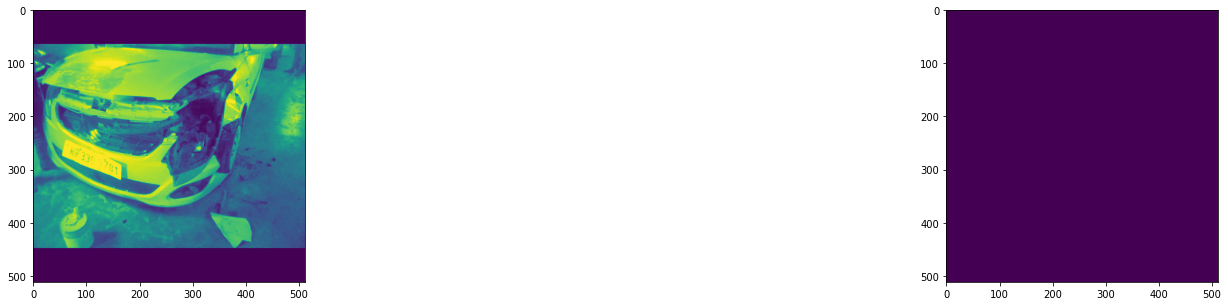

torch.Size([23, 512, 512])


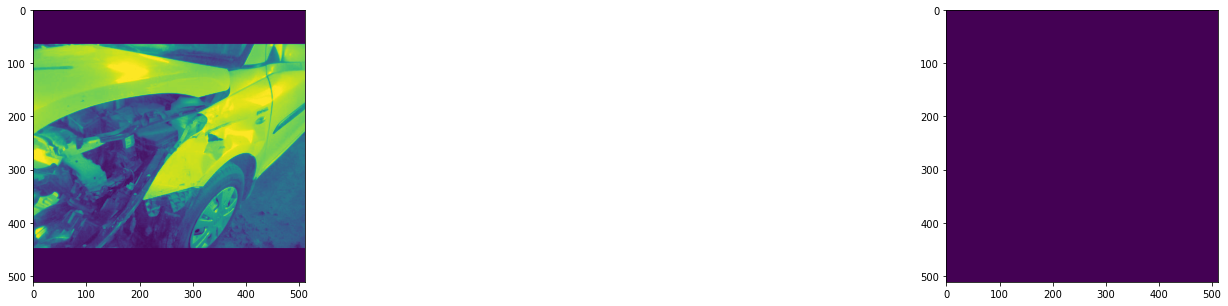

torch.Size([23, 512, 512])


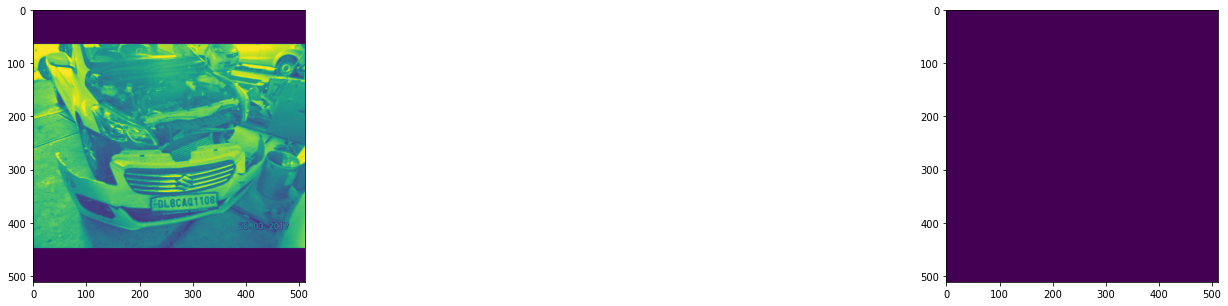

torch.Size([23, 512, 512])


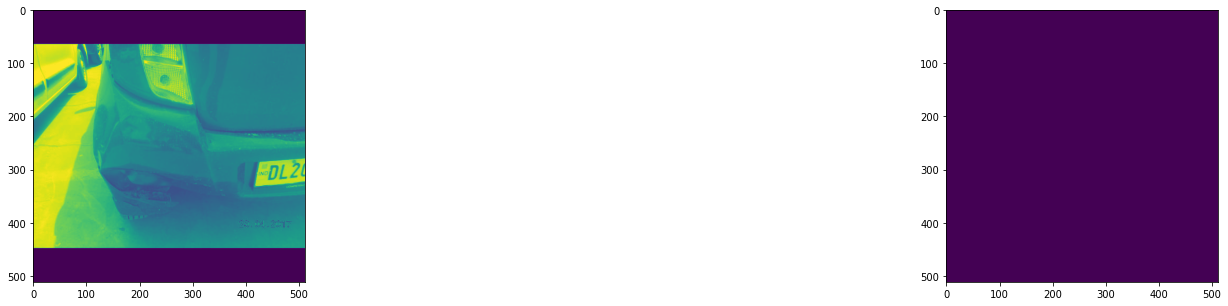

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):
    print(segmentation.shape)
    # Change the channel ordering
    image = np.moveaxis(image.numpy()*255, 0, -1)
    # print(image.shape)

    # Showing the image
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image[:, :, 0])
    plt.subplot(1,2,2)
    plt.imshow(segmentation[10])
    plt.show()

In [ ]:
segmentation.shape

torch.Size([23, 512, 512])

# Creating the Model

Here we will get setting up the model architecture, optimizer and loss.



In [ ]:
ENCODER = 'timm-efficientnet-b1'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = "softmax2d" 
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(train_dataset.labels),
    in_channels=1,
    activation=ACTIVATION,
)

# Hyperparameters & Metrics

In [ ]:
%cd /content/segmentation_models.pytorch/segmentation_models_pytorch

/content/segmentation_models.pytorch/segmentation_models_pytorch


In [ ]:
# using DiceLoss
loss = smp.utils.losses.DiceLoss()

# using multiple metrics to train the model
metrics = [
    smp.utils.metrics.IoU(threshold=0.9),
    smp.utils.metrics.Fscore(threshold=0.9),
    smp.utils.metrics.Accuracy(threshold=0.9),
    smp.utils.metrics.Recall(threshold=0.9),
    smp.utils.metrics.Precision(threshold=0.9),
]

# Using SGD optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Training the Model

**Saved Model and be loaded here and and trained**

In [ ]:
# Setting up training epoch to train the model
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
    )

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
    )

### **Model is saved based on the validation F1 Score** 

In [ ]:
cd /content/segmentation_models.pytorch

/content/segmentation_models.pytorch


In [ ]:
max_score = 1

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = val_epoch.run(val_loader) 
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        # torch.save(model, 'best_model.pth')
        # print('Model saved!')
        
    if i == 5:
        # lr is reduced 
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s, dice_loss - 0.1017, iou_score - 0.8192, fscore - 0.8983, accuracy - 0.9912, recall - 0.8983, precision - 0.8983]

Epoch: 1
valid: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s, dice_loss - 0.1017, iou_score - 0.8192, fscore - 0.8983, accuracy - 0.9912, recall - 0.8983, precision - 0.8983]

Epoch: 2
valid: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s, dice_loss - 0.1017, iou_score - 0.8192, fscore - 0.8983, accuracy - 0.9912, recall - 0.8983, precision - 0.8983]

Epoch: 3
valid: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s, dice_loss - 0.1017, iou_score - 0.8192, fscore - 0.8983, accuracy - 0.9912, recall - 0.8983, precision - 0.8983]

Epoch: 4
valid: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s, dice_loss - 0.1017, iou_score - 0.8192, fscore - 0.8983, accuracy - 0.9912, recall - 0.8983, precision - 0.8983]

Epoch: 5
valid: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s, dice_loss - 0.1017, iou_score - 0.8192, fscor

# Generating Predictions

In [ ]:
# Creating the testing dataset
data_dir_ = "./dataset"

test_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir_,"val/image"), train=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2, shuffle=False, drop_last=False)

## Load the best model

In [ ]:
# load the best model
model = torch.load("./best_model.pth")

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-56-25d024296863>:2 in <module>                                             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/torch/serialization.py:699 in load                 │
│                                                                                           │
│    696 │   if 'encoding' not in pickle_load_args.keys():                                  │
│    697 │   │   pickle_load_args['encoding'] = 'utf-8'                                     │
│    698 │                                                                                  │
│ ❱  699 │   with _open_file_like(f, 'rb') as opened_file:                                  │
│    700 │   │   if _is_zipfile(opened_file):                                               │
│    701 │   │   │   # The zipfile reader is going to advance the current file position.    │
│    702 │   │   │   # If we want to actually tail call to torch.jit.load, we need to       │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/torch/serialization.py:230 in _open_file_like      │
│                                                                                           │
│    227                                                                                    │
│    228 def _open_file_like(name_or_buffer, mode):                                         │
│    229 │   if _is_path(name_or_buffer):                                                   │
│ ❱  230 │   │   return _open_file(name_or_buffer, mode)                                    │
│    231 │   else:                                                                          │
│    232 │   │   if 'w' in mode:                                                            │
│    233 │   │   │   return _open_buffer_writer(name_or_buffer)                             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/torch/serialization.py:211 in __init__             │
│                                                                                           │
│    208                                                                                    │
│    209 class _open_file(_opener):                                                         │
│    210 │   def __init__(self, name, mode):                                                │
│ ❱  211 │   │   super(_open_file, self).__init__(open(name, mode))                         │
│    212 │                                                                                  │
│    213 │   def __exit__(self, *args):                                                     │
│    214 │   │   self.file_like.close()                                                     │
╰───────────────────────────────────────────────────

In [ ]:
# Generating Model Predictions
!rm -rf segmentation
!mkdir segmentation

for n, batch in enumerate(tqdm(test_loader)):

    # Getting the predictions
    predictions = model.predict(batch.to(DEVICE)).cpu() 
  
    # Converting the predictions to right format
    prediction_mask = (predictions.squeeze().cpu().numpy())   
    prediction_mask = np.transpose(prediction_mask, (1, 2, 0))

    # Getting individual channel and combining them into single image
    prediction_mask_gray = np.zeros((prediction_mask.shape[0],prediction_mask.shape[1]))
    for ii in range(prediction_mask.shape[2]):
        prediction_mask_gray = prediction_mask_gray + ii*prediction_mask[:,:,ii].round()


    # Saving the image
    prediction_mask_gray = Image.fromarray(prediction_mask_gray.astype(np.uint8))
    prediction_mask_gray.save(os.path.join("segmentation", f"{n}.png"))

  0%|          | 0/61 [00:00<?, ?it/s]

## Analyze the Predictions

In [ ]:
# Creating the testing dataset
data_dir_ = "./dataset"

test_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir_,"val/image"),
                                           label_directory=os.path.join("segmentation"))
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=False)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(test_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 23, 512, 512]))

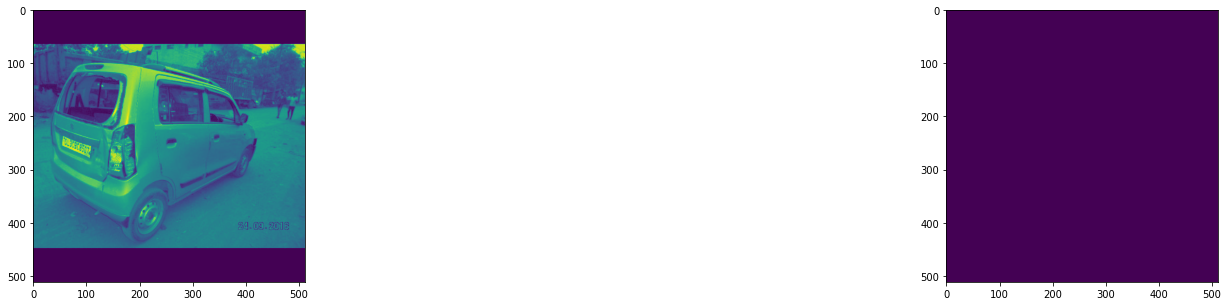

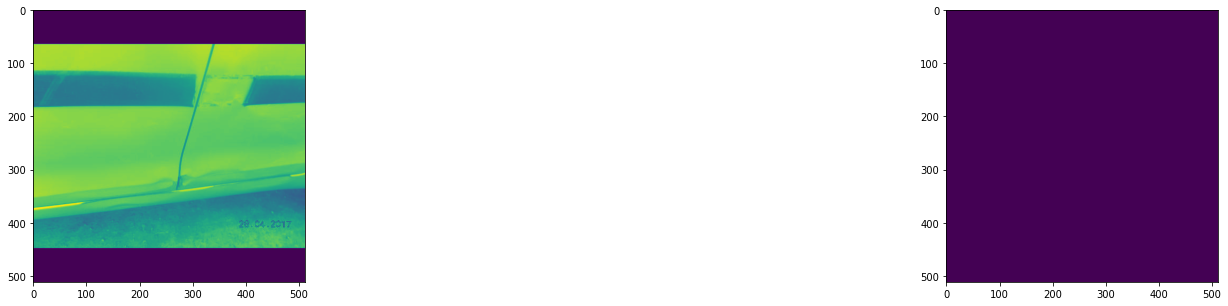

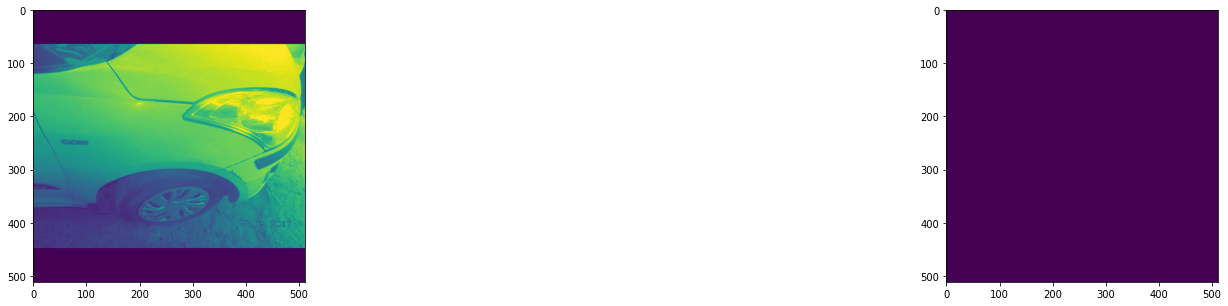

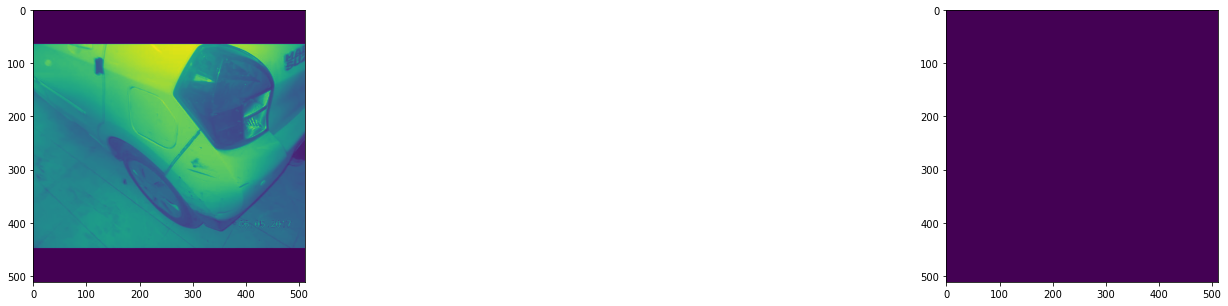

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

    # Change the channel ordering
    image = np.moveaxis(image.numpy()*255, 0, -1)

    # Showing the image
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image[:, :, 0])
    plt.subplot(1,2,2)
    plt.imshow(segmentation[1]*255)
    plt.show()

Image Size (512, 512, 3)
Mask Size (512, 512)


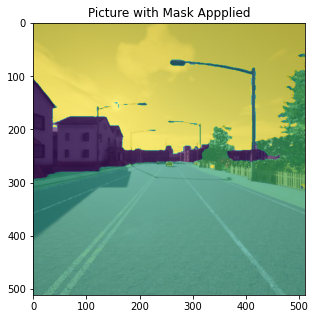

In [ ]:
id = 432
img = Image.open("data/test/image/"+str(id)+".jpg")
mask = Image.open("segmentation/" + str(id) + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Submitting our Predictions
**Note : Please save the notebook before submitting it (Ctrl + S)**

In [ ]:

COLORMAP = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [255, 255, 0],
                [0, 0, 255]]


CLASSES = ['background', 'scratch', 'dent', 'spacing', 'broken']

In [ ]:

def colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label


def label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [ ]:
label_indices(train_labels[0], colormap2label())
y[105:115, 130:140], CLASSES[1]

In [ ]:
import os
import torch
import torchvision
from d2l import torch as d2l

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-97-bdcfafe2de7a>:4 in <module>                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'd2l'